In [70]:
#This first chunk just imports some modules we will be using
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import numpy as np
import random
import pandas as pd
from subprocess import check_output
##This sets addresses for the training and test datasets.
## If you are running this on your own machine, you'll need to place the fashion-mnist_train and fashion-mnist_test
## csv files into the same directory as this file and change the dirrectory path below.





In [71]:
## We need to import the files into 

df = pd.read_csv('chinese_mnist.csv')

In [72]:
print(df.head())


   suite_id  sample_id  code  value character
0  1         1          10    9      九       
1  1         10         10    9      九       
2  1         2          10    9      九       
3  1         3          10    9      九       
4  1         4          10    9      九       


Okay, this is just the labeling of the data -- the actual images are stored in another folder called 'Data.'

The first (unlabeled) column is an id column. 

The second one labels the "suite" -- basically which person was drawing the characters. Each of the 100 volunteers created 10 samples, and each sample contains 15 characters ("codes"), so we should have 15000 rows. 

The last two columns contain the numerical value of the character (1-10, then the next 5 powers of 10) and the character itself. We will use the value column quite a bit as a label. 



There's something a little annoying about the data frame: the "finest" part of the counter (code) is not moving the fastest. 


In [73]:
def reindex(suite_id, sample_id, code):
    index = 150*(suite_id-1)+ 15*(sample_id-1) + code
    return index-1
    
print(reindex(1,10,9))

143


In [74]:


df['index'] = df.apply(lambda x: reindex(x.suite_id,x.sample_id,x.code),axis=1)


In [75]:
print(df.shape)

(15000, 6)


In [76]:
print(df.head(20))

    suite_id  sample_id  code  value character  index
0   1         1          10    9      九         9    
1   1         10         10    9      九         144  
2   1         2          10    9      九         24   
3   1         3          10    9      九         39   
4   1         4          10    9      九         54   
5   1         5          10    9      九         69   
6   1         6          10    9      九         84   
7   1         7          10    9      九         99   
8   1         8          10    9      九         114  
9   1         9          10    9      九         129  
10  10        1          10    9      九         1359 
11  10        10         10    9      九         1494 
12  10        2          10    9      九         1374 
13  10        3          10    9      九         1389 
14  10        4          10    9      九         1404 
15  10        5          10    9      九         1419 
16  10        6          10    9      九         1434 
17  10        7          10 

In [77]:
df = df.sort_values(by='index')

In [78]:
print(df.head(20))

       suite_id  sample_id  code      value character  index
6000   1         1          1     0          零         0    
7000   1         1          2     1          一         1    
8000   1         1          3     2          二         2    
9000   1         1          4     3          三         3    
10000  1         1          5     4          四         4    
11000  1         1          6     5          五         5    
12000  1         1          7     6          六         6    
13000  1         1          8     7          七         7    
14000  1         1          9     8          八         8    
0      1         1          10    9          九         9    
1000   1         1          11    10         十         10   
2000   1         1          12    100        百         11   
3000   1         1          13    1000       千         12   
4000   1         1          14    10000      万         13   
5000   1         1          15    100000000  亿         14   
6002   1         2      

In [79]:
df = df.set_index('index')

In [80]:
print(df.head())

       suite_id  sample_id  code  value character
index                                            
0      1         1          1     0      零       
1      1         1          2     1      一       
2      1         1          3     2      二       
3      1         1          4     3      三       
4      1         1          5     4      四       


The important thing for us is the value of each row (we do not expect suite_id, sample_id, or code to have meaning for an image classification task, and character is redundant with value). Now we actually need the training features, and we have to get all the images wrangled into the dataframe.

In [81]:
images = []

for i in range(1,101):
    for j in range(1,11):
        for k in range(1,16):
            index  = reindex(i,j,k)
            filename = '_'.join([str(i),str(j),str(k)])
            filename = 'input_'+filename + '.jpg'
            path = 'data/'+filename
            img = mpimg.imread(path).flatten()
            images += [img]




In [82]:
features = np.array(images)

In [83]:
type(images)

list

In [84]:
df['image'] = images

This is great, now we have a properly indexed dataframe. Let's check to make sure the actual images line up with the data. We pick a random entry from the character column, and note that the image does seem to match the character stored in the character column :). 

In [85]:
num = random.randrange(0,15000)

print(df['character'][num])

三


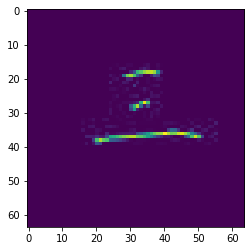

In [86]:
image = df['image'][num]
reshaped_image = np.reshape(image, (64, 64))
plt.imshow(reshaped_image)

Now that we know the characters and the images line up correctly, we can discard those columns.

In [87]:
df = df.drop(columns = ['suite_id','sample_id','code','character'])
print(df.head(10))

       value  \
index          
0      0       
1      1       
2      2       
3      3       
4      4       
5      5       
6      6       
7      7       
8      8       
9      9       

                                                                                                                                                                                                                                                                                                                   image  
index                                                                                                                                                                                                                                                                                                                     
0      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Now we have a pretty useful form for the datframe: an index column, a label column ('value') and a feature column ('image'). We scale the image values so that they are all between 0 and 1.

In [45]:
features = features/255

Unfortunately, numpy arrays don't allow string inputs, and we don't want a one hundred million-vector to represent fifteen possible values. So we will code the values as 100 = 11, 1000 = 12, 10000 = 13, 

In [93]:
def number_changer(num):
    if num > 10000:
        num = 14
    elif num > 1000:
        num = 13
    elif num > 100: 
        num = 12
    elif num > 10:
        num = 11
    return num

In [94]:
df['changed_value'] = df.apply(lambda x: number_changer(x.value), axis=1)



In [95]:
labels = df['changed_value']
labels = labels.to_numpy()

In [96]:
for t in range(30):
    print(labels[t])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


We peel the values off the dataframe into a numpy array, the preferred input for fitting a keras model. 

In [97]:
labels = tf.keras.utils.to_categorical(labels)

In [98]:
len(labels[0])

15

Now we split up the data into training and test sets. We could do this "by hand" if we wanted to, but it's nice to let sklearns's split package do the work.

In [103]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(features, labels)



The commands below cast the 15 possible labels in a one-to-hot encoding (example: if the label is 4, then it becomes a vector of length 15 with 0's everywhere except in the fourth position, where the value is 1). 

In [104]:
#This specifies the size of the model for us 
#(it is still "empty" as it has not been compiled or trained)
# Think of this as the blueprint for the model before it has been built
# Each Dense layer is fully connected to the previous layer
# The integer argument specifies the number of nodes
# The activation is set to Rectified Linear Unit = (0.5)*(x+|x|)
# Which is the standard activation for each node, 
# replacing the earlier standards of sigmoid and hyperbolic tangent.

model  = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(30,activation=tf.nn.relu,input_shape=(4096,)))
model.add(tf.keras.layers.Dense(20,activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(15,activation=tf.nn.softmax))

## Now we "compile" the model -- we actually build it!

# We also specify a loss function (this is what the NN will try
# to minimize during training), an optimizer (this is the 
# method by which the NN tries to minimize the loss),
# and a metric (this is the metric by which we judge the performance
# of the algorithm at its assigned task -- in this case classification)
# The difference between loss and non-accuracy is a little subtle
# Basically the job of the loss function is to be something that is 
# easy to calculate and optimize, and hopefully by minimizing loss
# we get something that maximizes accuracy. 

# Think of this as putting in the wiring and plumbing and light fixtures

model.compile(loss = 'categorical_crossentropy',
              optimizer = 'rmsprop',
              metrics = ['accuracy'])


#note that the metrics argument is a list, because we can ask the 
#NN to calculate as many metrics as we like. We can only specify a single
# loss function and optimizer though (although you could probably 
#stitch together several loss functions using a max or sum). 

model.summary()

#after we print the model summary we see that there are 23550=785*30 
# = 28*28*30 + 30
#parameters for the first layer. Each of the 28*28*30 corresponds to 
# one pixel being added to one of the nodes in the first layer,
#whereas the others are weights (I think) for the 30 nodes

#Likewise we get 620 = 30*20 + 20 params for the second layer, the
# 30*20 corresponding to the connections between nodes in the first 
#and second layers and the 20 corresponding to weights on the
#second layer nodes themselves. And the pattern continues in the third 
#layer. IF we had chosen a non-Dense layer, then not every node 
#would connect to every node in the adjacent layers, and we 
#would have fewer parameters (probably there is some reason to try this)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 30)                122910    
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 15)                315       
Total params: 123,845
Trainable params: 123,845
Non-trainable params: 0
_________________________________________________________________


In [108]:

## This just specifies how often we feed the training data into the network (epochs is roughly the number 
## of iterations and batch is the amount of data fed each time). 

epochs_no = 100
batch_no = 128



The command below fits the neural network to the training data. 

In [109]:
model.fit(train_features,train_labels,epochs=epochs_no,batch_size=batch_no)

Epoch 1/100
88/88 [==============================] - 0s 2ms/step - loss: 1.2826 - accuracy: 0.5451
Epoch 2/100
88/88 [==============================] - 0s 1ms/step - loss: 1.2066 - accuracy: 0.5713
Epoch 3/100
88/88 [==============================] - 0s 1ms/step - loss: 1.1411 - accuracy: 0.5940
Epoch 4/100
88/88 [==============================] - 0s 1ms/step - loss: 1.0735 - accuracy: 0.6204
Epoch 5/100
88/88 [==============================] - 0s 1ms/step - loss: 1.0194 - accuracy: 0.6386
Epoch 6/100
88/88 [==============================] - 0s 1ms/step - loss: 0.9611 - accuracy: 0.6570
Epoch 7/100
88/88 [==============================] - 0s 1ms/step - loss: 0.9122 - accuracy: 0.6718
Epoch 8/100
88/88 [==============================] - 0s 1ms/step - loss: 0.8710 - accuracy: 0.6881
Epoch 9/100
88/88 [==============================] - 0s 1ms/step - loss: 0.8410 - accuracy: 0.6960
Epoch 10/100
88/88 [==============================] - 0s 2ms/step - loss: 0.8016 - accuracy: 0.7108
Epoch 11/

88/88 [==============================] - 0s 1ms/step - loss: 0.1771 - accuracy: 0.9404
Epoch 84/100
88/88 [==============================] - 0s 1ms/step - loss: 0.1821 - accuracy: 0.9386
Epoch 85/100
88/88 [==============================] - 0s 1ms/step - loss: 0.1782 - accuracy: 0.9398
Epoch 86/100
88/88 [==============================] - 0s 1ms/step - loss: 0.1805 - accuracy: 0.9398
Epoch 87/100
88/88 [==============================] - 0s 1ms/step - loss: 0.1782 - accuracy: 0.9411
Epoch 88/100
88/88 [==============================] - 0s 1ms/step - loss: 0.1710 - accuracy: 0.9420
Epoch 89/100
88/88 [==============================] - 0s 1ms/step - loss: 0.1761 - accuracy: 0.9416
Epoch 90/100
88/88 [==============================] - 0s 1ms/step - loss: 0.1728 - accuracy: 0.9420
Epoch 91/100
88/88 [==============================] - 0s 1ms/step - loss: 0.1713 - accuracy: 0.9438
Epoch 92/100
88/88 [==============================] - 0s 1ms/step - loss: 0.1684 - accuracy: 0.9427
Epoch 93/100


In [ ]:
## The test accuracy

In [110]:
test_loss,test_acc = model.evaluate(test_features,test_labels)
print("Test accuracy is ",test_acc)

118/118 [==============================] - 0s 453us/step - loss: 9.2995 - accuracy: 0.5053
Test accuracy is  0.5053333044052124


We see that the test accuracy is considerably worse than the training accuracy -- this indicates severe 
overfitting. Let's try to find the "sweet spot" where we minimize bias+variance. For now we'll just tinker with the number of epochs.  

In [121]:
epoch_values = [t+1 for t in range(100)]

test_accuracy = []

for num in epoch_values:
    epochs_no = num
    model  = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(30,activation=tf.nn.relu,input_shape=(4096,)))
    model.add(tf.keras.layers.Dense(20,activation=tf.nn.relu))
    model.add(tf.keras.layers.Dense(15,activation=tf.nn.softmax))
    model.compile(loss = 'categorical_crossentropy',
              optimizer = 'rmsprop',
              metrics = ['accuracy'])
    batch_no = 128
    model.fit(train_features,train_labels,epochs=epochs_no,batch_size=batch_no)
    test_loss,test_acc = model.evaluate(test_features,test_labels)
    test_accuracy.append(test_acc)

    

118/118 [==============================] - 0s 479us/step - loss: 2.5588 - accuracy: 0.1656
Epoch 1/2
88/88 [==============================] - 0s 1ms/step - loss: 3.2986 - accuracy: 0.1057
Epoch 2/2
118/118 [==============================] - 0s 469us/step - loss: 2.4152 - accuracy: 0.2352
Epoch 1/3
88/88 [==============================] - 0s 1ms/step - loss: 3.2166 - accuracy: 0.1292
Epoch 2/3
88/88 [==============================] - 0s 1ms/step - loss: 2.3244 - accuracy: 0.2418
Epoch 3/3
118/118 [==============================] - 0s 474us/step - loss: 2.0347 - accuracy: 0.3485
Epoch 1/4
88/88 [==============================] - 0s 1ms/step - loss: 3.2664 - accuracy: 0.1321
Epoch 2/4
88/88 [==============================] - 0s 1ms/step - loss: 2.3630 - accuracy: 0.2240
Epoch 3/4
88/88 [==============================] - 0s 1ms/step - loss: 2.1552 - accuracy: 0.2961
Epoch 4/4
118/118 [==============================] - 0s 472us/step - loss: 2.0499 - accuracy: 0.3600
Epoch 1/5
88/88 [=======

88/88 [==============================] - 0s 1ms/step - loss: 1.2499 - accuracy: 0.5616
Epoch 9/12
88/88 [==============================] - 0s 1ms/step - loss: 1.1200 - accuracy: 0.5991
Epoch 10/12
88/88 [==============================] - 0s 1ms/step - loss: 1.0302 - accuracy: 0.6315
Epoch 11/12
88/88 [==============================] - 0s 1ms/step - loss: 0.9457 - accuracy: 0.6525
Epoch 12/12
118/118 [==============================] - 0s 447us/step - loss: 1.8462 - accuracy: 0.5520
Epoch 1/13
88/88 [==============================] - 0s 1ms/step - loss: 3.1154 - accuracy: 0.1279
Epoch 2/13
88/88 [==============================] - 0s 1ms/step - loss: 2.2782 - accuracy: 0.2683
Epoch 3/13
88/88 [==============================] - 0s 1ms/step - loss: 1.9589 - accuracy: 0.3551
Epoch 4/13
88/88 [==============================] - 0s 1ms/step - loss: 1.7330 - accuracy: 0.4132
Epoch 5/13
88/88 [==============================] - 0s 1ms/step - loss: 1.5474 - accuracy: 0.4788
Epoch 6/13
88/88 [======

88/88 [==============================] - 0s 1ms/step - loss: 0.6432 - accuracy: 0.7671
Epoch 17/17
118/118 [==============================] - 0s 450us/step - loss: 1.9271 - accuracy: 0.5629
Epoch 1/18
88/88 [==============================] - 0s 1ms/step - loss: 3.3214 - accuracy: 0.1413
Epoch 2/18
88/88 [==============================] - 0s 1ms/step - loss: 2.2605 - accuracy: 0.2691
Epoch 3/18
88/88 [==============================] - 0s 1ms/step - loss: 1.9893 - accuracy: 0.3381
Epoch 4/18
88/88 [==============================] - 0s 1ms/step - loss: 1.8173 - accuracy: 0.3762
Epoch 5/18
88/88 [==============================] - 0s 1ms/step - loss: 1.6829 - accuracy: 0.4312
Epoch 6/18
88/88 [==============================] - 0s 1ms/step - loss: 1.5684 - accuracy: 0.4677
Epoch 7/18
88/88 [==============================] - 0s 1ms/step - loss: 1.4539 - accuracy: 0.5058
Epoch 8/18
88/88 [==============================] - 0s 1ms/step - loss: 1.3712 - accuracy: 0.5321
Epoch 9/18
88/88 [========

118/118 [==============================] - 0s 441us/step - loss: 2.2158 - accuracy: 0.5368
Epoch 1/22
88/88 [==============================] - 0s 1ms/step - loss: 3.2948 - accuracy: 0.0924
Epoch 2/22
88/88 [==============================] - 0s 1ms/step - loss: 2.4225 - accuracy: 0.2213
Epoch 3/22
88/88 [==============================] - 0s 1ms/step - loss: 2.1713 - accuracy: 0.2902
Epoch 4/22
88/88 [==============================] - 0s 1ms/step - loss: 1.9924 - accuracy: 0.3377
Epoch 5/22
88/88 [==============================] - 0s 1ms/step - loss: 1.8169 - accuracy: 0.3697
Epoch 6/22
88/88 [==============================] - 0s 1ms/step - loss: 1.6799 - accuracy: 0.4357
Epoch 7/22
88/88 [==============================] - 0s 1ms/step - loss: 1.5689 - accuracy: 0.4796
Epoch 8/22
88/88 [==============================] - 0s 1ms/step - loss: 1.4768 - accuracy: 0.5015
Epoch 9/22
88/88 [==============================] - 0s 1ms/step - loss: 1.3926 - accuracy: 0.5270
Epoch 10/22
88/88 [========

88/88 [==============================] - 0s 1ms/step - loss: 1.0245 - accuracy: 0.6456
Epoch 11/25
88/88 [==============================] - 0s 1ms/step - loss: 0.9523 - accuracy: 0.6652
Epoch 12/25
88/88 [==============================] - 0s 1ms/step - loss: 0.8837 - accuracy: 0.6923
Epoch 13/25
88/88 [==============================] - 0s 1ms/step - loss: 0.8181 - accuracy: 0.7124
Epoch 14/25
88/88 [==============================] - 0s 1ms/step - loss: 0.7759 - accuracy: 0.7297
Epoch 15/25
88/88 [==============================] - 0s 1ms/step - loss: 0.7214 - accuracy: 0.7452
Epoch 16/25
88/88 [==============================] - 0s 1ms/step - loss: 0.6761 - accuracy: 0.7568
Epoch 17/25
88/88 [==============================] - 0s 1ms/step - loss: 0.6268 - accuracy: 0.7780
Epoch 18/25
88/88 [==============================] - 0s 1ms/step - loss: 0.5971 - accuracy: 0.7869
Epoch 19/25
88/88 [==============================] - 0s 1ms/step - loss: 0.5675 - accuracy: 0.7978
Epoch 20/25
88/88 [===

88/88 [==============================] - 0s 1ms/step - loss: 1.1019 - accuracy: 0.6108
Epoch 13/28
88/88 [==============================] - 0s 1ms/step - loss: 1.0547 - accuracy: 0.6308
Epoch 14/28
88/88 [==============================] - 0s 1ms/step - loss: 1.0049 - accuracy: 0.6452
Epoch 15/28
88/88 [==============================] - 0s 1ms/step - loss: 0.9633 - accuracy: 0.6607
Epoch 16/28
88/88 [==============================] - 0s 1ms/step - loss: 0.9257 - accuracy: 0.6719
Epoch 17/28
88/88 [==============================] - 0s 1ms/step - loss: 0.8861 - accuracy: 0.6858
Epoch 18/28
88/88 [==============================] - 0s 1ms/step - loss: 0.8521 - accuracy: 0.6956
Epoch 19/28
88/88 [==============================] - 0s 1ms/step - loss: 0.8246 - accuracy: 0.7104
Epoch 20/28
88/88 [==============================] - 0s 1ms/step - loss: 0.7926 - accuracy: 0.7196
Epoch 21/28
88/88 [==============================] - 0s 1ms/step - loss: 0.7634 - accuracy: 0.7250
Epoch 22/28
88/88 [===

88/88 [==============================] - 0s 1ms/step - loss: 1.6893 - accuracy: 0.4364
Epoch 6/31
88/88 [==============================] - 0s 1ms/step - loss: 1.5537 - accuracy: 0.4700
Epoch 7/31
88/88 [==============================] - 0s 1ms/step - loss: 1.4440 - accuracy: 0.5098
Epoch 8/31
88/88 [==============================] - 0s 1ms/step - loss: 1.3476 - accuracy: 0.5364
Epoch 9/31
88/88 [==============================] - 0s 1ms/step - loss: 1.2647 - accuracy: 0.5618
Epoch 10/31
88/88 [==============================] - 0s 1ms/step - loss: 1.1964 - accuracy: 0.5836
Epoch 11/31
88/88 [==============================] - 0s 1ms/step - loss: 1.1329 - accuracy: 0.6035
Epoch 12/31
88/88 [==============================] - 0s 1ms/step - loss: 1.0739 - accuracy: 0.6205
Epoch 13/31
88/88 [==============================] - 0s 1ms/step - loss: 1.0271 - accuracy: 0.6431
Epoch 14/31
88/88 [==============================] - 0s 1ms/step - loss: 0.9784 - accuracy: 0.6587
Epoch 15/31
88/88 [=======

88/88 [==============================] - 0s 1ms/step - loss: 0.6593 - accuracy: 0.7633
Epoch 24/33
88/88 [==============================] - 0s 1ms/step - loss: 0.6396 - accuracy: 0.7651
Epoch 25/33
88/88 [==============================] - 0s 1ms/step - loss: 0.6153 - accuracy: 0.7741
Epoch 26/33
88/88 [==============================] - 0s 1ms/step - loss: 0.5932 - accuracy: 0.7804
Epoch 27/33
88/88 [==============================] - 0s 1ms/step - loss: 0.5744 - accuracy: 0.7923
Epoch 28/33
88/88 [==============================] - 0s 1ms/step - loss: 0.5623 - accuracy: 0.7939
Epoch 29/33
88/88 [==============================] - 0s 1ms/step - loss: 0.5424 - accuracy: 0.8046
Epoch 30/33
88/88 [==============================] - 0s 1ms/step - loss: 0.5256 - accuracy: 0.8057
Epoch 31/33
88/88 [==============================] - 0s 1ms/step - loss: 0.5142 - accuracy: 0.8106
Epoch 32/33
88/88 [==============================] - 0s 1ms/step - loss: 0.5018 - accuracy: 0.8164
Epoch 33/33
118/118 [=

88/88 [==============================] - 0s 1ms/step - loss: 3.2144 - accuracy: 0.0899
Epoch 2/36
88/88 [==============================] - 0s 1ms/step - loss: 2.3997 - accuracy: 0.1852
Epoch 3/36
88/88 [==============================] - 0s 1ms/step - loss: 2.1332 - accuracy: 0.2664
Epoch 4/36
88/88 [==============================] - 0s 1ms/step - loss: 1.9372 - accuracy: 0.3173
Epoch 5/36
88/88 [==============================] - 0s 1ms/step - loss: 1.7997 - accuracy: 0.3676
Epoch 6/36
88/88 [==============================] - 0s 1ms/step - loss: 1.6867 - accuracy: 0.4037
Epoch 7/36
88/88 [==============================] - 0s 1ms/step - loss: 1.5886 - accuracy: 0.4339
Epoch 8/36
88/88 [==============================] - 0s 1ms/step - loss: 1.5124 - accuracy: 0.4606
Epoch 9/36
88/88 [==============================] - 0s 1ms/step - loss: 1.4374 - accuracy: 0.4854
Epoch 10/36
88/88 [==============================] - 0s 1ms/step - loss: 1.3703 - accuracy: 0.5151
Epoch 11/36
88/88 [===========

88/88 [==============================] - 0s 1ms/step - loss: 1.1562 - accuracy: 0.5868
Epoch 10/38
88/88 [==============================] - 0s 1ms/step - loss: 1.0727 - accuracy: 0.6126
Epoch 11/38
88/88 [==============================] - 0s 1ms/step - loss: 1.0094 - accuracy: 0.6422
Epoch 12/38
88/88 [==============================] - 0s 1ms/step - loss: 0.9503 - accuracy: 0.6607
Epoch 13/38
88/88 [==============================] - 0s 1ms/step - loss: 0.9019 - accuracy: 0.6773
Epoch 14/38
88/88 [==============================] - 0s 1ms/step - loss: 0.8486 - accuracy: 0.6953
Epoch 15/38
88/88 [==============================] - 0s 1ms/step - loss: 0.8007 - accuracy: 0.7101
Epoch 16/38
88/88 [==============================] - 0s 1ms/step - loss: 0.7626 - accuracy: 0.7239
Epoch 17/38
88/88 [==============================] - 0s 1ms/step - loss: 0.7230 - accuracy: 0.7387
Epoch 18/38
88/88 [==============================] - 0s 1ms/step - loss: 0.6928 - accuracy: 0.7495
Epoch 19/38
88/88 [===

88/88 [==============================] - 0s 1ms/step - loss: 0.9854 - accuracy: 0.6588
Epoch 14/40
88/88 [==============================] - 0s 1ms/step - loss: 0.9451 - accuracy: 0.6708
Epoch 15/40
88/88 [==============================] - 0s 1ms/step - loss: 0.8999 - accuracy: 0.6856
Epoch 16/40
88/88 [==============================] - 0s 1ms/step - loss: 0.8622 - accuracy: 0.6942
Epoch 17/40
88/88 [==============================] - 0s 1ms/step - loss: 0.8296 - accuracy: 0.7107
Epoch 18/40
88/88 [==============================] - 0s 1ms/step - loss: 0.7960 - accuracy: 0.7193
Epoch 19/40
88/88 [==============================] - 0s 1ms/step - loss: 0.7605 - accuracy: 0.7366
Epoch 20/40
88/88 [==============================] - 0s 1ms/step - loss: 0.7361 - accuracy: 0.7440
Epoch 21/40
88/88 [==============================] - 0s 1ms/step - loss: 0.7067 - accuracy: 0.7531
Epoch 22/40
88/88 [==============================] - 0s 1ms/step - loss: 0.6858 - accuracy: 0.7632
Epoch 23/40
88/88 [===

88/88 [==============================] - 0s 1ms/step - loss: 1.0961 - accuracy: 0.6126
Epoch 14/42
88/88 [==============================] - 0s 1ms/step - loss: 1.0439 - accuracy: 0.6284
Epoch 15/42
88/88 [==============================] - 0s 1ms/step - loss: 0.9983 - accuracy: 0.6403
Epoch 16/42
88/88 [==============================] - 0s 1ms/step - loss: 0.9594 - accuracy: 0.6561
Epoch 17/42
88/88 [==============================] - 0s 1ms/step - loss: 0.9289 - accuracy: 0.6668
Epoch 18/42
88/88 [==============================] - 0s 1ms/step - loss: 0.8842 - accuracy: 0.6840
Epoch 19/42
88/88 [==============================] - 0s 1ms/step - loss: 0.8662 - accuracy: 0.6909
Epoch 20/42
88/88 [==============================] - 0s 1ms/step - loss: 0.8231 - accuracy: 0.7043
Epoch 21/42
88/88 [==============================] - 0s 1ms/step - loss: 0.8020 - accuracy: 0.7154
Epoch 22/42
88/88 [==============================] - 0s 1ms/step - loss: 0.7741 - accuracy: 0.7229
Epoch 23/42
88/88 [===

88/88 [==============================] - 0s 1ms/step - loss: 1.1880 - accuracy: 0.5753
Epoch 10/44
88/88 [==============================] - 0s 1ms/step - loss: 1.1133 - accuracy: 0.5986
Epoch 11/44
88/88 [==============================] - 0s 1ms/step - loss: 1.0544 - accuracy: 0.6241
Epoch 12/44
88/88 [==============================] - 0s 1ms/step - loss: 0.9920 - accuracy: 0.6455
Epoch 13/44
88/88 [==============================] - 0s 1ms/step - loss: 0.9315 - accuracy: 0.6634
Epoch 14/44
88/88 [==============================] - 0s 1ms/step - loss: 0.8840 - accuracy: 0.6828
Epoch 15/44
88/88 [==============================] - 0s 1ms/step - loss: 0.8425 - accuracy: 0.6959
Epoch 16/44
88/88 [==============================] - 0s 1ms/step - loss: 0.7948 - accuracy: 0.7133
Epoch 17/44
88/88 [==============================] - 0s 1ms/step - loss: 0.7567 - accuracy: 0.7326
Epoch 18/44
88/88 [==============================] - 0s 1ms/step - loss: 0.7297 - accuracy: 0.7465
Epoch 19/44
88/88 [===

88/88 [==============================] - 0s 1ms/step - loss: 3.2261 - accuracy: 0.0891
Epoch 2/46
88/88 [==============================] - 0s 1ms/step - loss: 2.5689 - accuracy: 0.1626
Epoch 3/46
88/88 [==============================] - 0s 1ms/step - loss: 2.3603 - accuracy: 0.2309
Epoch 4/46
88/88 [==============================] - 0s 1ms/step - loss: 2.1765 - accuracy: 0.2884
Epoch 5/46
88/88 [==============================] - 0s 1ms/step - loss: 2.0147 - accuracy: 0.3268
Epoch 6/46
88/88 [==============================] - 0s 1ms/step - loss: 1.8548 - accuracy: 0.3719
Epoch 7/46
88/88 [==============================] - 0s 1ms/step - loss: 1.7141 - accuracy: 0.4155
Epoch 8/46
88/88 [==============================] - 0s 1ms/step - loss: 1.5726 - accuracy: 0.4500
Epoch 9/46
88/88 [==============================] - 0s 1ms/step - loss: 1.4339 - accuracy: 0.4868
Epoch 10/46
88/88 [==============================] - 0s 1ms/step - loss: 1.3271 - accuracy: 0.5219
Epoch 11/46
88/88 [===========

88/88 [==============================] - 0s 1ms/step - loss: 1.2017 - accuracy: 0.5516
Epoch 38/47
88/88 [==============================] - 0s 1ms/step - loss: 1.1949 - accuracy: 0.5560
Epoch 39/47
88/88 [==============================] - 0s 1ms/step - loss: 1.1917 - accuracy: 0.5599
Epoch 40/47
88/88 [==============================] - 0s 1ms/step - loss: 1.1744 - accuracy: 0.5625
Epoch 41/47
88/88 [==============================] - 0s 1ms/step - loss: 1.1656 - accuracy: 0.5660
Epoch 42/47
88/88 [==============================] - 0s 1ms/step - loss: 1.1611 - accuracy: 0.5678
Epoch 43/47
88/88 [==============================] - 0s 1ms/step - loss: 1.1512 - accuracy: 0.5731
Epoch 44/47
88/88 [==============================] - 0s 1ms/step - loss: 1.1547 - accuracy: 0.5724
Epoch 45/47
88/88 [==============================] - 0s 1ms/step - loss: 1.1327 - accuracy: 0.5766
Epoch 46/47
88/88 [==============================] - 0s 1ms/step - loss: 1.1323 - accuracy: 0.5808
Epoch 47/47
118/118 [=

88/88 [==============================] - 0s 1ms/step - loss: 0.7647 - accuracy: 0.7277
Epoch 24/49
88/88 [==============================] - 0s 1ms/step - loss: 0.7468 - accuracy: 0.7392
Epoch 25/49
88/88 [==============================] - 0s 1ms/step - loss: 0.7287 - accuracy: 0.7481
Epoch 26/49
88/88 [==============================] - 0s 1ms/step - loss: 0.7114 - accuracy: 0.7559
Epoch 27/49
88/88 [==============================] - 0s 1ms/step - loss: 0.6965 - accuracy: 0.7591
Epoch 28/49
88/88 [==============================] - 0s 1ms/step - loss: 0.6768 - accuracy: 0.7660
Epoch 29/49
88/88 [==============================] - 0s 1ms/step - loss: 0.6702 - accuracy: 0.7726
Epoch 30/49
88/88 [==============================] - 0s 1ms/step - loss: 0.6474 - accuracy: 0.7809
Epoch 31/49
88/88 [==============================] - 0s 1ms/step - loss: 0.6359 - accuracy: 0.7895
Epoch 32/49
88/88 [==============================] - 0s 1ms/step - loss: 0.6328 - accuracy: 0.7903
Epoch 33/49
88/88 [===

88/88 [==============================] - 0s 1ms/step - loss: 1.7233 - accuracy: 0.4370
Epoch 6/51
88/88 [==============================] - 0s 1ms/step - loss: 1.5748 - accuracy: 0.4807
Epoch 7/51
88/88 [==============================] - 0s 1ms/step - loss: 1.4411 - accuracy: 0.5132
Epoch 8/51
88/88 [==============================] - 0s 1ms/step - loss: 1.3483 - accuracy: 0.5438
Epoch 9/51
88/88 [==============================] - 0s 1ms/step - loss: 1.2668 - accuracy: 0.5642
Epoch 10/51
88/88 [==============================] - 0s 1ms/step - loss: 1.1874 - accuracy: 0.5864
Epoch 11/51
88/88 [==============================] - 0s 1ms/step - loss: 1.1278 - accuracy: 0.6015
Epoch 12/51
88/88 [==============================] - 0s 1ms/step - loss: 1.0652 - accuracy: 0.6172
Epoch 13/51
88/88 [==============================] - 0s 1ms/step - loss: 1.0129 - accuracy: 0.6423
Epoch 14/51
88/88 [==============================] - 0s 1ms/step - loss: 0.9538 - accuracy: 0.6609
Epoch 15/51
88/88 [=======

88/88 [==============================] - 0s 1ms/step - loss: 0.4183 - accuracy: 0.8637
Epoch 37/52
88/88 [==============================] - 0s 1ms/step - loss: 0.4070 - accuracy: 0.8676
Epoch 38/52
88/88 [==============================] - 0s 1ms/step - loss: 0.3994 - accuracy: 0.8722
Epoch 39/52
88/88 [==============================] - 0s 1ms/step - loss: 0.3954 - accuracy: 0.8740
Epoch 40/52
88/88 [==============================] - 0s 1ms/step - loss: 0.3841 - accuracy: 0.8766
Epoch 41/52
88/88 [==============================] - 0s 1ms/step - loss: 0.3758 - accuracy: 0.8791
Epoch 42/52
88/88 [==============================] - 0s 1ms/step - loss: 0.3651 - accuracy: 0.8841
Epoch 43/52
88/88 [==============================] - 0s 1ms/step - loss: 0.3665 - accuracy: 0.8867
Epoch 44/52
88/88 [==============================] - 0s 1ms/step - loss: 0.3541 - accuracy: 0.8877
Epoch 45/52
88/88 [==============================] - 0s 1ms/step - loss: 0.3399 - accuracy: 0.8926
Epoch 46/52
88/88 [===

88/88 [==============================] - 0s 1ms/step - loss: 1.1067 - accuracy: 0.6237
Epoch 13/54
88/88 [==============================] - 0s 1ms/step - loss: 1.0472 - accuracy: 0.6456
Epoch 14/54
88/88 [==============================] - 0s 1ms/step - loss: 0.9938 - accuracy: 0.6611
Epoch 15/54
88/88 [==============================] - 0s 1ms/step - loss: 0.9395 - accuracy: 0.6804
Epoch 16/54
88/88 [==============================] - 0s 1ms/step - loss: 0.8927 - accuracy: 0.6934
Epoch 17/54
88/88 [==============================] - 0s 1ms/step - loss: 0.8480 - accuracy: 0.7081
Epoch 18/54
88/88 [==============================] - 0s 1ms/step - loss: 0.8158 - accuracy: 0.7190
Epoch 19/54
88/88 [==============================] - 0s 1ms/step - loss: 0.7793 - accuracy: 0.7324
Epoch 20/54
88/88 [==============================] - 0s 1ms/step - loss: 0.7504 - accuracy: 0.7388
Epoch 21/54
88/88 [==============================] - 0s 1ms/step - loss: 0.7234 - accuracy: 0.7513
Epoch 22/54
88/88 [===

88/88 [==============================] - 0s 1ms/step - loss: 0.5877 - accuracy: 0.7979
Epoch 41/55
88/88 [==============================] - 0s 1ms/step - loss: 0.5791 - accuracy: 0.7992
Epoch 42/55
88/88 [==============================] - 0s 1ms/step - loss: 0.5737 - accuracy: 0.8065
Epoch 43/55
88/88 [==============================] - 0s 1ms/step - loss: 0.5689 - accuracy: 0.8096
Epoch 44/55
88/88 [==============================] - 0s 1ms/step - loss: 0.5525 - accuracy: 0.8148
Epoch 45/55
88/88 [==============================] - 0s 1ms/step - loss: 0.5492 - accuracy: 0.8172
Epoch 46/55
88/88 [==============================] - 0s 1ms/step - loss: 0.5325 - accuracy: 0.8173
Epoch 47/55
88/88 [==============================] - 0s 1ms/step - loss: 0.5287 - accuracy: 0.8256
Epoch 48/55
88/88 [==============================] - 0s 1ms/step - loss: 0.5228 - accuracy: 0.8238
Epoch 49/55
88/88 [==============================] - 0s 1ms/step - loss: 0.5195 - accuracy: 0.8254
Epoch 50/55
88/88 [===

88/88 [==============================] - 0s 1ms/step - loss: 1.0870 - accuracy: 0.6057
Epoch 11/57
88/88 [==============================] - 0s 1ms/step - loss: 1.0035 - accuracy: 0.6373
Epoch 12/57
88/88 [==============================] - 0s 1ms/step - loss: 0.9351 - accuracy: 0.6656
Epoch 13/57
88/88 [==============================] - 0s 1ms/step - loss: 0.8721 - accuracy: 0.6816
Epoch 14/57
88/88 [==============================] - 0s 1ms/step - loss: 0.8127 - accuracy: 0.7065
Epoch 15/57
88/88 [==============================] - 0s 1ms/step - loss: 0.7608 - accuracy: 0.7215
Epoch 16/57
88/88 [==============================] - 0s 1ms/step - loss: 0.7110 - accuracy: 0.7389
Epoch 17/57
88/88 [==============================] - 0s 1ms/step - loss: 0.6784 - accuracy: 0.7532
Epoch 18/57
88/88 [==============================] - 0s 1ms/step - loss: 0.6298 - accuracy: 0.7675
Epoch 19/57
88/88 [==============================] - 0s 1ms/step - loss: 0.6025 - accuracy: 0.7788
Epoch 20/57
88/88 [===

88/88 [==============================] - 0s 1ms/step - loss: 0.2805 - accuracy: 0.9064
Epoch 36/58
88/88 [==============================] - 0s 1ms/step - loss: 0.2627 - accuracy: 0.9135
Epoch 37/58
88/88 [==============================] - 0s 1ms/step - loss: 0.2617 - accuracy: 0.9153
Epoch 38/58
88/88 [==============================] - 0s 1ms/step - loss: 0.2495 - accuracy: 0.9199
Epoch 39/58
88/88 [==============================] - 0s 1ms/step - loss: 0.2372 - accuracy: 0.9227
Epoch 40/58
88/88 [==============================] - 0s 1ms/step - loss: 0.2397 - accuracy: 0.9212
Epoch 41/58
88/88 [==============================] - 0s 1ms/step - loss: 0.2268 - accuracy: 0.9261
Epoch 42/58
88/88 [==============================] - 0s 1ms/step - loss: 0.2227 - accuracy: 0.9273
Epoch 43/58
88/88 [==============================] - 0s 1ms/step - loss: 0.2174 - accuracy: 0.9308
Epoch 44/58
88/88 [==============================] - 0s 1ms/step - loss: 0.2118 - accuracy: 0.9300
Epoch 45/58
88/88 [===

118/118 [==============================] - 0s 443us/step - loss: 5.1237 - accuracy: 0.5408
Epoch 1/60
88/88 [==============================] - 0s 1ms/step - loss: 3.3466 - accuracy: 0.1198
Epoch 2/60
88/88 [==============================] - 0s 1ms/step - loss: 2.3816 - accuracy: 0.2395
Epoch 3/60
88/88 [==============================] - 0s 1ms/step - loss: 2.1598 - accuracy: 0.3095
Epoch 4/60
88/88 [==============================] - 0s 1ms/step - loss: 1.9581 - accuracy: 0.3572
Epoch 5/60
88/88 [==============================] - 0s 1ms/step - loss: 1.8030 - accuracy: 0.4015
Epoch 6/60
88/88 [==============================] - 0s 1ms/step - loss: 1.6532 - accuracy: 0.4431
Epoch 7/60
88/88 [==============================] - 0s 1ms/step - loss: 1.5277 - accuracy: 0.4827
Epoch 8/60
88/88 [==============================] - 0s 1ms/step - loss: 1.4285 - accuracy: 0.5055
Epoch 9/60
88/88 [==============================] - 0s 1ms/step - loss: 1.3256 - accuracy: 0.5388
Epoch 10/60
88/88 [========

88/88 [==============================] - 0s 1ms/step - loss: 1.1030 - accuracy: 0.5972
Epoch 22/61
88/88 [==============================] - 0s 1ms/step - loss: 1.0728 - accuracy: 0.6052
Epoch 23/61
88/88 [==============================] - 0s 1ms/step - loss: 1.0483 - accuracy: 0.6168
Epoch 24/61
88/88 [==============================] - 0s 1ms/step - loss: 1.0238 - accuracy: 0.6233
Epoch 25/61
88/88 [==============================] - 0s 1ms/step - loss: 0.9945 - accuracy: 0.6318
Epoch 26/61
88/88 [==============================] - 0s 1ms/step - loss: 0.9722 - accuracy: 0.6432
Epoch 27/61
88/88 [==============================] - 0s 1ms/step - loss: 0.9545 - accuracy: 0.6492
Epoch 28/61
88/88 [==============================] - 0s 1ms/step - loss: 0.9296 - accuracy: 0.6564
Epoch 29/61
88/88 [==============================] - 0s 1ms/step - loss: 0.9137 - accuracy: 0.6626
Epoch 30/61
88/88 [==============================] - 0s 1ms/step - loss: 0.8882 - accuracy: 0.6739
Epoch 31/61
88/88 [===

88/88 [==============================] - 0s 1ms/step - loss: 0.3905 - accuracy: 0.8627
Epoch 43/62
88/88 [==============================] - 0s 1ms/step - loss: 0.3883 - accuracy: 0.8653
Epoch 44/62
88/88 [==============================] - 0s 1ms/step - loss: 0.3798 - accuracy: 0.8703
Epoch 45/62
88/88 [==============================] - 0s 1ms/step - loss: 0.3745 - accuracy: 0.8724
Epoch 46/62
88/88 [==============================] - 0s 1ms/step - loss: 0.3674 - accuracy: 0.8733
Epoch 47/62
88/88 [==============================] - 0s 1ms/step - loss: 0.3588 - accuracy: 0.8772
Epoch 48/62
88/88 [==============================] - 0s 1ms/step - loss: 0.3447 - accuracy: 0.8796
Epoch 49/62
88/88 [==============================] - 0s 1ms/step - loss: 0.3456 - accuracy: 0.8816
Epoch 50/62
88/88 [==============================] - 0s 1ms/step - loss: 0.3404 - accuracy: 0.8853
Epoch 51/62
88/88 [==============================] - 0s 1ms/step - loss: 0.3292 - accuracy: 0.8868
Epoch 52/62
88/88 [===

88/88 [==============================] - 0s 1ms/step - loss: 0.3806 - accuracy: 0.8739
Epoch 63/63
118/118 [==============================] - 0s 444us/step - loss: 4.3351 - accuracy: 0.5317
Epoch 1/64
88/88 [==============================] - 0s 1ms/step - loss: 3.1555 - accuracy: 0.1717
Epoch 2/64
88/88 [==============================] - 0s 1ms/step - loss: 2.1648 - accuracy: 0.3028
Epoch 3/64
88/88 [==============================] - 0s 1ms/step - loss: 1.8572 - accuracy: 0.3809
Epoch 4/64
88/88 [==============================] - 0s 1ms/step - loss: 1.6136 - accuracy: 0.4498
Epoch 5/64
88/88 [==============================] - 0s 1ms/step - loss: 1.3966 - accuracy: 0.5195
Epoch 6/64
88/88 [==============================] - 0s 1ms/step - loss: 1.2062 - accuracy: 0.5788
Epoch 7/64
88/88 [==============================] - 0s 1ms/step - loss: 1.0702 - accuracy: 0.6214
Epoch 8/64
88/88 [==============================] - 0s 1ms/step - loss: 0.9682 - accuracy: 0.6535
Epoch 9/64
88/88 [========

88/88 [==============================] - 0s 1ms/step - loss: 1.7017 - accuracy: 0.3959
Epoch 17/65
88/88 [==============================] - 0s 1ms/step - loss: 1.6664 - accuracy: 0.4018
Epoch 18/65
88/88 [==============================] - 0s 1ms/step - loss: 1.6506 - accuracy: 0.4109
Epoch 19/65
88/88 [==============================] - 0s 1ms/step - loss: 1.6264 - accuracy: 0.4209
Epoch 20/65
88/88 [==============================] - 0s 1ms/step - loss: 1.5902 - accuracy: 0.4292
Epoch 21/65
88/88 [==============================] - 0s 1ms/step - loss: 1.5767 - accuracy: 0.4360
Epoch 22/65
88/88 [==============================] - 0s 1ms/step - loss: 1.5525 - accuracy: 0.4382
Epoch 23/65
88/88 [==============================] - 0s 1ms/step - loss: 1.5304 - accuracy: 0.4439
Epoch 24/65
88/88 [==============================] - 0s 1ms/step - loss: 1.5200 - accuracy: 0.4514
Epoch 25/65
88/88 [==============================] - 0s 1ms/step - loss: 1.4943 - accuracy: 0.4581
Epoch 26/65
88/88 [===

88/88 [==============================] - 0s 1ms/step - loss: 0.5205 - accuracy: 0.8224
Epoch 34/66
88/88 [==============================] - 0s 1ms/step - loss: 0.5068 - accuracy: 0.8254
Epoch 35/66
88/88 [==============================] - 0s 1ms/step - loss: 0.4943 - accuracy: 0.8330
Epoch 36/66
88/88 [==============================] - 0s 1ms/step - loss: 0.4824 - accuracy: 0.8340
Epoch 37/66
88/88 [==============================] - 0s 1ms/step - loss: 0.4763 - accuracy: 0.8390
Epoch 38/66
88/88 [==============================] - 0s 1ms/step - loss: 0.4671 - accuracy: 0.8389
Epoch 39/66
88/88 [==============================] - 0s 1ms/step - loss: 0.4597 - accuracy: 0.8463
Epoch 40/66
88/88 [==============================] - 0s 1ms/step - loss: 0.4505 - accuracy: 0.8484
Epoch 41/66
88/88 [==============================] - 0s 1ms/step - loss: 0.4378 - accuracy: 0.8533
Epoch 42/66
88/88 [==============================] - 0s 1ms/step - loss: 0.4325 - accuracy: 0.8537
Epoch 43/66
88/88 [===

88/88 [==============================] - 0s 1ms/step - loss: 0.2810 - accuracy: 0.9079
Epoch 50/67
88/88 [==============================] - 0s 1ms/step - loss: 0.2860 - accuracy: 0.9052
Epoch 51/67
88/88 [==============================] - 0s 1ms/step - loss: 0.2713 - accuracy: 0.9093
Epoch 52/67
88/88 [==============================] - 0s 1ms/step - loss: 0.2677 - accuracy: 0.9128
Epoch 53/67
88/88 [==============================] - 0s 1ms/step - loss: 0.2620 - accuracy: 0.9136
Epoch 54/67
88/88 [==============================] - 0s 1ms/step - loss: 0.2479 - accuracy: 0.9178
Epoch 55/67
88/88 [==============================] - 0s 1ms/step - loss: 0.2585 - accuracy: 0.9163
Epoch 56/67
88/88 [==============================] - 0s 1ms/step - loss: 0.2450 - accuracy: 0.9175
Epoch 57/67
88/88 [==============================] - 0s 1ms/step - loss: 0.2479 - accuracy: 0.9198
Epoch 58/67
88/88 [==============================] - 0s 1ms/step - loss: 0.2404 - accuracy: 0.9212
Epoch 59/67
88/88 [===

88/88 [==============================] - 0s 1ms/step - loss: 0.4530 - accuracy: 0.8402
Epoch 65/68
88/88 [==============================] - 0s 1ms/step - loss: 0.4541 - accuracy: 0.8431
Epoch 66/68
88/88 [==============================] - 0s 1ms/step - loss: 0.4444 - accuracy: 0.8431
Epoch 67/68
88/88 [==============================] - 0s 1ms/step - loss: 0.4369 - accuracy: 0.8482
Epoch 68/68
118/118 [==============================] - 0s 462us/step - loss: 4.7099 - accuracy: 0.5149
Epoch 1/69
88/88 [==============================] - 0s 1ms/step - loss: 2.9016 - accuracy: 0.0988
Epoch 2/69
88/88 [==============================] - 0s 1ms/step - loss: 2.4884 - accuracy: 0.1867
Epoch 3/69
88/88 [==============================] - 0s 1ms/step - loss: 2.2527 - accuracy: 0.2572
Epoch 4/69
88/88 [==============================] - 0s 1ms/step - loss: 2.0644 - accuracy: 0.3071
Epoch 5/69
88/88 [==============================] - 0s 1ms/step - loss: 1.9245 - accuracy: 0.3454
Epoch 6/69
88/88 [=====

88/88 [==============================] - 0s 1ms/step - loss: 1.5443 - accuracy: 0.4630
Epoch 9/70
88/88 [==============================] - 0s 1ms/step - loss: 1.4654 - accuracy: 0.4926
Epoch 10/70
88/88 [==============================] - 0s 1ms/step - loss: 1.3834 - accuracy: 0.5181
Epoch 11/70
88/88 [==============================] - 0s 1ms/step - loss: 1.3113 - accuracy: 0.5410
Epoch 12/70
88/88 [==============================] - 0s 1ms/step - loss: 1.2386 - accuracy: 0.5663
Epoch 13/70
88/88 [==============================] - 0s 1ms/step - loss: 1.1792 - accuracy: 0.5820
Epoch 14/70
88/88 [==============================] - 0s 1ms/step - loss: 1.1234 - accuracy: 0.6092
Epoch 15/70
88/88 [==============================] - 0s 1ms/step - loss: 1.0694 - accuracy: 0.6270
Epoch 16/70
88/88 [==============================] - 0s 1ms/step - loss: 1.0177 - accuracy: 0.6444
Epoch 17/70
88/88 [==============================] - 0s 1ms/step - loss: 0.9706 - accuracy: 0.6633
Epoch 18/70
88/88 [====

88/88 [==============================] - 0s 1ms/step - loss: 0.6415 - accuracy: 0.7697
Epoch 21/71
88/88 [==============================] - 0s 1ms/step - loss: 0.6087 - accuracy: 0.7868
Epoch 22/71
88/88 [==============================] - 0s 1ms/step - loss: 0.5756 - accuracy: 0.7966
Epoch 23/71
88/88 [==============================] - 0s 1ms/step - loss: 0.5447 - accuracy: 0.8076
Epoch 24/71
88/88 [==============================] - 0s 1ms/step - loss: 0.5229 - accuracy: 0.8165
Epoch 25/71
88/88 [==============================] - 0s 1ms/step - loss: 0.5033 - accuracy: 0.8239
Epoch 26/71
88/88 [==============================] - 0s 1ms/step - loss: 0.4808 - accuracy: 0.8340
Epoch 27/71
88/88 [==============================] - 0s 1ms/step - loss: 0.4464 - accuracy: 0.8424
Epoch 28/71
88/88 [==============================] - 0s 1ms/step - loss: 0.4372 - accuracy: 0.8452
Epoch 29/71
88/88 [==============================] - 0s 1ms/step - loss: 0.4115 - accuracy: 0.8566
Epoch 30/71
88/88 [===

88/88 [==============================] - 0s 1ms/step - loss: 0.5777 - accuracy: 0.7809
Epoch 32/72
88/88 [==============================] - 0s 1ms/step - loss: 0.5654 - accuracy: 0.7832
Epoch 33/72
88/88 [==============================] - 0s 1ms/step - loss: 0.5612 - accuracy: 0.7879
Epoch 34/72
88/88 [==============================] - 0s 1ms/step - loss: 0.5440 - accuracy: 0.7952
Epoch 35/72
88/88 [==============================] - 0s 1ms/step - loss: 0.5276 - accuracy: 0.8003
Epoch 36/72
88/88 [==============================] - 0s 1ms/step - loss: 0.5311 - accuracy: 0.7986
Epoch 37/72
88/88 [==============================] - 0s 1ms/step - loss: 0.5174 - accuracy: 0.8021
Epoch 38/72
88/88 [==============================] - 0s 1ms/step - loss: 0.5155 - accuracy: 0.8071
Epoch 39/72
88/88 [==============================] - 0s 1ms/step - loss: 0.5096 - accuracy: 0.8113
Epoch 40/72
88/88 [==============================] - 0s 1ms/step - loss: 0.4994 - accuracy: 0.8132
Epoch 41/72
88/88 [===

88/88 [==============================] - 0s 1ms/step - loss: 0.4157 - accuracy: 0.8488
Epoch 42/73
88/88 [==============================] - 0s 1ms/step - loss: 0.4142 - accuracy: 0.8527
Epoch 43/73
88/88 [==============================] - 0s 1ms/step - loss: 0.4070 - accuracy: 0.8513
Epoch 44/73
88/88 [==============================] - 0s 1ms/step - loss: 0.3962 - accuracy: 0.8598
Epoch 45/73
88/88 [==============================] - 0s 1ms/step - loss: 0.3919 - accuracy: 0.8592
Epoch 46/73
88/88 [==============================] - 0s 1ms/step - loss: 0.3835 - accuracy: 0.8607
Epoch 47/73
88/88 [==============================] - 0s 1ms/step - loss: 0.3772 - accuracy: 0.8644
Epoch 48/73
88/88 [==============================] - 0s 1ms/step - loss: 0.3698 - accuracy: 0.8659
Epoch 49/73
88/88 [==============================] - 0s 1ms/step - loss: 0.3660 - accuracy: 0.8673
Epoch 50/73
88/88 [==============================] - 0s 1ms/step - loss: 0.3615 - accuracy: 0.8694
Epoch 51/73
88/88 [===

88/88 [==============================] - 0s 1ms/step - loss: 0.2516 - accuracy: 0.9164
Epoch 51/74
88/88 [==============================] - 0s 1ms/step - loss: 0.2479 - accuracy: 0.9200
Epoch 52/74
88/88 [==============================] - 0s 1ms/step - loss: 0.2369 - accuracy: 0.9236
Epoch 53/74
88/88 [==============================] - 0s 1ms/step - loss: 0.2339 - accuracy: 0.9229
Epoch 54/74
88/88 [==============================] - 0s 1ms/step - loss: 0.2392 - accuracy: 0.9248
Epoch 55/74
88/88 [==============================] - 0s 1ms/step - loss: 0.2270 - accuracy: 0.9241
Epoch 56/74
88/88 [==============================] - 0s 1ms/step - loss: 0.2267 - accuracy: 0.9297
Epoch 57/74
88/88 [==============================] - 0s 1ms/step - loss: 0.2262 - accuracy: 0.9287
Epoch 58/74
88/88 [==============================] - 0s 1ms/step - loss: 0.2215 - accuracy: 0.9288
Epoch 59/74
88/88 [==============================] - 0s 1ms/step - loss: 0.2145 - accuracy: 0.9307
Epoch 60/74
88/88 [===

88/88 [==============================] - 0s 1ms/step - loss: 0.2755 - accuracy: 0.9093
Epoch 59/75
88/88 [==============================] - 0s 1ms/step - loss: 0.2699 - accuracy: 0.9117
Epoch 60/75
88/88 [==============================] - 0s 1ms/step - loss: 0.2650 - accuracy: 0.9157
Epoch 61/75
88/88 [==============================] - 0s 1ms/step - loss: 0.2600 - accuracy: 0.9156
Epoch 62/75
88/88 [==============================] - 0s 1ms/step - loss: 0.2620 - accuracy: 0.9146
Epoch 63/75
88/88 [==============================] - 0s 1ms/step - loss: 0.2527 - accuracy: 0.9184
Epoch 64/75
88/88 [==============================] - 0s 1ms/step - loss: 0.2532 - accuracy: 0.9175
Epoch 65/75
88/88 [==============================] - 0s 1ms/step - loss: 0.2420 - accuracy: 0.9212
Epoch 66/75
88/88 [==============================] - 0s 1ms/step - loss: 0.2495 - accuracy: 0.9213
Epoch 67/75
88/88 [==============================] - 0s 1ms/step - loss: 0.2453 - accuracy: 0.9220
Epoch 68/75
88/88 [===

88/88 [==============================] - 0s 1ms/step - loss: 0.6020 - accuracy: 0.7747
Epoch 66/76
88/88 [==============================] - 0s 1ms/step - loss: 0.5874 - accuracy: 0.7778
Epoch 67/76
88/88 [==============================] - 0s 1ms/step - loss: 0.5886 - accuracy: 0.7796
Epoch 68/76
88/88 [==============================] - 0s 1ms/step - loss: 0.5900 - accuracy: 0.7793
Epoch 69/76
88/88 [==============================] - 0s 1ms/step - loss: 0.5847 - accuracy: 0.7818
Epoch 70/76
88/88 [==============================] - 0s 1ms/step - loss: 0.5797 - accuracy: 0.7833
Epoch 71/76
88/88 [==============================] - 0s 1ms/step - loss: 0.5786 - accuracy: 0.7818
Epoch 72/76
88/88 [==============================] - 0s 1ms/step - loss: 0.5708 - accuracy: 0.7832
Epoch 73/76
88/88 [==============================] - 0s 1ms/step - loss: 0.5811 - accuracy: 0.7846
Epoch 74/76
88/88 [==============================] - 0s 1ms/step - loss: 0.5704 - accuracy: 0.7868
Epoch 75/76
88/88 [===

88/88 [==============================] - 0s 1ms/step - loss: 0.1311 - accuracy: 0.9608
Epoch 72/77
88/88 [==============================] - 0s 1ms/step - loss: 0.1107 - accuracy: 0.9647
Epoch 73/77
88/88 [==============================] - 0s 1ms/step - loss: 0.1171 - accuracy: 0.9654
Epoch 74/77
88/88 [==============================] - 0s 1ms/step - loss: 0.1153 - accuracy: 0.9654
Epoch 75/77
88/88 [==============================] - 0s 1ms/step - loss: 0.1095 - accuracy: 0.9670
Epoch 76/77
88/88 [==============================] - 0s 1ms/step - loss: 0.1093 - accuracy: 0.9660
Epoch 77/77
118/118 [==============================] - 0s 445us/step - loss: 8.2157 - accuracy: 0.5483
Epoch 1/78
88/88 [==============================] - 0s 1ms/step - loss: 3.0864 - accuracy: 0.1116
Epoch 2/78
88/88 [==============================] - 0s 1ms/step - loss: 2.3789 - accuracy: 0.2121
Epoch 3/78
88/88 [==============================] - 0s 1ms/step - loss: 2.1313 - accuracy: 0.2900
Epoch 4/78
88/88 [===

88/88 [==============================] - 0s 1ms/step - loss: 0.2300 - accuracy: 0.9161
Epoch 77/78
88/88 [==============================] - 0s 1ms/step - loss: 0.2282 - accuracy: 0.9153
Epoch 78/78
118/118 [==============================] - 0s 446us/step - loss: 6.1568 - accuracy: 0.5336
Epoch 1/79
88/88 [==============================] - 0s 1ms/step - loss: 3.3060 - accuracy: 0.1204
Epoch 2/79
88/88 [==============================] - 0s 1ms/step - loss: 2.3157 - accuracy: 0.2348
Epoch 3/79
88/88 [==============================] - 0s 1ms/step - loss: 1.9956 - accuracy: 0.3223
Epoch 4/79
88/88 [==============================] - 0s 1ms/step - loss: 1.7653 - accuracy: 0.3935
Epoch 5/79
88/88 [==============================] - 0s 1ms/step - loss: 1.5749 - accuracy: 0.4467
Epoch 6/79
88/88 [==============================] - 0s 1ms/step - loss: 1.4280 - accuracy: 0.4913
Epoch 7/79
88/88 [==============================] - 0s 1ms/step - loss: 1.2846 - accuracy: 0.5403
Epoch 8/79
88/88 [=======

118/118 [==============================] - 0s 456us/step - loss: 7.9210 - accuracy: 0.5552
Epoch 1/80
88/88 [==============================] - 0s 1ms/step - loss: 2.9660 - accuracy: 0.1416
Epoch 2/80
88/88 [==============================] - 0s 1ms/step - loss: 2.2630 - accuracy: 0.2699
Epoch 3/80
88/88 [==============================] - 0s 1ms/step - loss: 1.9643 - accuracy: 0.3679
Epoch 4/80
88/88 [==============================] - 0s 1ms/step - loss: 1.7052 - accuracy: 0.4316
Epoch 5/80
88/88 [==============================] - 0s 1ms/step - loss: 1.5351 - accuracy: 0.4724
Epoch 6/80
88/88 [==============================] - 0s 1ms/step - loss: 1.3913 - accuracy: 0.5108
Epoch 7/80
88/88 [==============================] - 0s 1ms/step - loss: 1.2609 - accuracy: 0.5518
Epoch 8/80
88/88 [==============================] - 0s 1ms/step - loss: 1.1644 - accuracy: 0.5836
Epoch 9/80
88/88 [==============================] - 0s 1ms/step - loss: 1.0825 - accuracy: 0.6096
Epoch 10/80
88/88 [========

88/88 [==============================] - 0s 1ms/step - loss: 2.3647 - accuracy: 0.2190
Epoch 3/81
88/88 [==============================] - 0s 1ms/step - loss: 2.1028 - accuracy: 0.3040
Epoch 4/81
88/88 [==============================] - 0s 1ms/step - loss: 1.9233 - accuracy: 0.3574
Epoch 5/81
88/88 [==============================] - 0s 1ms/step - loss: 1.7653 - accuracy: 0.4015
Epoch 6/81
88/88 [==============================] - 0s 1ms/step - loss: 1.6302 - accuracy: 0.4374
Epoch 7/81
88/88 [==============================] - 0s 1ms/step - loss: 1.4899 - accuracy: 0.4819
Epoch 8/81
88/88 [==============================] - 0s 1ms/step - loss: 1.3779 - accuracy: 0.5096
Epoch 9/81
88/88 [==============================] - 0s 1ms/step - loss: 1.2781 - accuracy: 0.5467
Epoch 10/81
88/88 [==============================] - 0s 1ms/step - loss: 1.1941 - accuracy: 0.5738
Epoch 11/81
88/88 [==============================] - 0s 1ms/step - loss: 1.1233 - accuracy: 0.6010
Epoch 12/81
88/88 [==========

88/88 [==============================] - 0s 1ms/step - loss: 2.0181 - accuracy: 0.3303
Epoch 4/82
88/88 [==============================] - 0s 1ms/step - loss: 1.8661 - accuracy: 0.3692
Epoch 5/82
88/88 [==============================] - 0s 1ms/step - loss: 1.7370 - accuracy: 0.4044
Epoch 6/82
88/88 [==============================] - 0s 1ms/step - loss: 1.6037 - accuracy: 0.4456
Epoch 7/82
88/88 [==============================] - 0s 1ms/step - loss: 1.4924 - accuracy: 0.4809
Epoch 8/82
88/88 [==============================] - 0s 1ms/step - loss: 1.3909 - accuracy: 0.5172
Epoch 9/82
88/88 [==============================] - 0s 1ms/step - loss: 1.2983 - accuracy: 0.5489
Epoch 10/82
88/88 [==============================] - 0s 1ms/step - loss: 1.2262 - accuracy: 0.5712
Epoch 11/82
88/88 [==============================] - 0s 1ms/step - loss: 1.1519 - accuracy: 0.5972
Epoch 12/82
88/88 [==============================] - 0s 1ms/step - loss: 1.0861 - accuracy: 0.6182
Epoch 13/82
88/88 [=========

88/88 [==============================] - 0s 1ms/step - loss: 2.0439 - accuracy: 0.3402
Epoch 4/83
88/88 [==============================] - 0s 1ms/step - loss: 1.8489 - accuracy: 0.3900
Epoch 5/83
88/88 [==============================] - 0s 1ms/step - loss: 1.6763 - accuracy: 0.4372
Epoch 6/83
88/88 [==============================] - 0s 1ms/step - loss: 1.5186 - accuracy: 0.4741
Epoch 7/83
88/88 [==============================] - 0s 1ms/step - loss: 1.3834 - accuracy: 0.5151
Epoch 8/83
88/88 [==============================] - 0s 1ms/step - loss: 1.2591 - accuracy: 0.5508
Epoch 9/83
88/88 [==============================] - 0s 1ms/step - loss: 1.1696 - accuracy: 0.5796
Epoch 10/83
88/88 [==============================] - 0s 1ms/step - loss: 1.0959 - accuracy: 0.6040
Epoch 11/83
88/88 [==============================] - 0s 1ms/step - loss: 1.0278 - accuracy: 0.6327
Epoch 12/83
88/88 [==============================] - 0s 1ms/step - loss: 0.9662 - accuracy: 0.6436
Epoch 13/83
88/88 [=========

88/88 [==============================] - 0s 1ms/step - loss: 2.3934 - accuracy: 0.2073
Epoch 3/84
88/88 [==============================] - 0s 1ms/step - loss: 2.2073 - accuracy: 0.2740
Epoch 4/84
88/88 [==============================] - 0s 1ms/step - loss: 2.0292 - accuracy: 0.3282
Epoch 5/84
88/88 [==============================] - 0s 1ms/step - loss: 1.8915 - accuracy: 0.3688
Epoch 6/84
88/88 [==============================] - 0s 1ms/step - loss: 1.7557 - accuracy: 0.4039
Epoch 7/84
88/88 [==============================] - 0s 1ms/step - loss: 1.6348 - accuracy: 0.4419
Epoch 8/84
88/88 [==============================] - 0s 1ms/step - loss: 1.5377 - accuracy: 0.4732
Epoch 9/84
88/88 [==============================] - 0s 1ms/step - loss: 1.4520 - accuracy: 0.4986
Epoch 10/84
88/88 [==============================] - 0s 1ms/step - loss: 1.3758 - accuracy: 0.5188
Epoch 11/84
88/88 [==============================] - 0s 1ms/step - loss: 1.3048 - accuracy: 0.5390
Epoch 12/84
88/88 [==========

118/118 [==============================] - 0s 453us/step - loss: 5.3194 - accuracy: 0.5549
Epoch 1/85
88/88 [==============================] - 0s 2ms/step - loss: 3.1279 - accuracy: 0.1438
Epoch 2/85
88/88 [==============================] - 0s 1ms/step - loss: 2.3128 - accuracy: 0.2660
Epoch 3/85
88/88 [==============================] - 0s 1ms/step - loss: 2.0285 - accuracy: 0.3426
Epoch 4/85
88/88 [==============================] - 0s 1ms/step - loss: 1.7905 - accuracy: 0.4012
Epoch 5/85
88/88 [==============================] - 0s 3ms/step - loss: 1.6234 - accuracy: 0.4463
Epoch 6/85
88/88 [==============================] - 0s 2ms/step - loss: 1.4870 - accuracy: 0.4794
Epoch 7/85
88/88 [==============================] - 0s 1ms/step - loss: 1.3758 - accuracy: 0.5127
Epoch 8/85
88/88 [==============================] - 0s 1ms/step - loss: 1.2693 - accuracy: 0.5439
Epoch 9/85
88/88 [==============================] - 0s 1ms/step - loss: 1.1756 - accuracy: 0.5874
Epoch 10/85
88/88 [========

88/88 [==============================] - 0s 1ms/step - loss: 0.2382 - accuracy: 0.9279
Epoch 83/85
88/88 [==============================] - 0s 1ms/step - loss: 0.2305 - accuracy: 0.9289
Epoch 84/85
88/88 [==============================] - 0s 1ms/step - loss: 0.2318 - accuracy: 0.9291
Epoch 85/85
118/118 [==============================] - 0s 449us/step - loss: 6.4059 - accuracy: 0.5496
Epoch 1/86
88/88 [==============================] - 0s 1ms/step - loss: 3.1974 - accuracy: 0.1265
Epoch 2/86
88/88 [==============================] - 0s 1ms/step - loss: 2.3376 - accuracy: 0.2364
Epoch 3/86
88/88 [==============================] - 0s 1ms/step - loss: 2.0449 - accuracy: 0.3258
Epoch 4/86
88/88 [==============================] - 0s 1ms/step - loss: 1.8130 - accuracy: 0.3879
Epoch 5/86
88/88 [==============================] - 0s 1ms/step - loss: 1.6137 - accuracy: 0.4495
Epoch 6/86
88/88 [==============================] - 0s 1ms/step - loss: 1.4330 - accuracy: 0.5086
Epoch 7/86
88/88 [======

88/88 [==============================] - 0s 1ms/step - loss: 0.1430 - accuracy: 0.9530
Epoch 80/86
88/88 [==============================] - 0s 1ms/step - loss: 0.1391 - accuracy: 0.9532
Epoch 81/86
88/88 [==============================] - 0s 1ms/step - loss: 0.1390 - accuracy: 0.9515
Epoch 82/86
88/88 [==============================] - 0s 1ms/step - loss: 0.1474 - accuracy: 0.9509
Epoch 83/86
88/88 [==============================] - 0s 1ms/step - loss: 0.1437 - accuracy: 0.9541
Epoch 84/86
88/88 [==============================] - 0s 1ms/step - loss: 0.1439 - accuracy: 0.9531
Epoch 85/86
88/88 [==============================] - 0s 1ms/step - loss: 0.1375 - accuracy: 0.9535
Epoch 86/86
118/118 [==============================] - 0s 464us/step - loss: 8.0800 - accuracy: 0.5592
Epoch 1/87
88/88 [==============================] - 0s 1ms/step - loss: 3.3164 - accuracy: 0.1376
Epoch 2/87
88/88 [==============================] - 0s 1ms/step - loss: 2.3361 - accuracy: 0.2541
Epoch 3/87
88/88 [==

88/88 [==============================] - 0s 1ms/step - loss: 0.1553 - accuracy: 0.9492
Epoch 76/87
88/88 [==============================] - 0s 1ms/step - loss: 0.1587 - accuracy: 0.9474
Epoch 77/87
88/88 [==============================] - 0s 1ms/step - loss: 0.1522 - accuracy: 0.9484
Epoch 78/87
88/88 [==============================] - 0s 1ms/step - loss: 0.1549 - accuracy: 0.9502
Epoch 79/87
88/88 [==============================] - 0s 1ms/step - loss: 0.1515 - accuracy: 0.9524
Epoch 80/87
88/88 [==============================] - 0s 1ms/step - loss: 0.1422 - accuracy: 0.9556
Epoch 81/87
88/88 [==============================] - 0s 1ms/step - loss: 0.1479 - accuracy: 0.9551
Epoch 82/87
88/88 [==============================] - 0s 1ms/step - loss: 0.1457 - accuracy: 0.9535
Epoch 83/87
88/88 [==============================] - 0s 1ms/step - loss: 0.1387 - accuracy: 0.9553
Epoch 84/87
88/88 [==============================] - 0s 1ms/step - loss: 0.1363 - accuracy: 0.9551
Epoch 85/87
88/88 [===

88/88 [==============================] - 0s 1ms/step - loss: 0.1907 - accuracy: 0.9375
Epoch 71/88
88/88 [==============================] - 0s 1ms/step - loss: 0.1919 - accuracy: 0.9378
Epoch 72/88
88/88 [==============================] - 0s 1ms/step - loss: 0.1849 - accuracy: 0.9384
Epoch 73/88
88/88 [==============================] - 0s 1ms/step - loss: 0.1864 - accuracy: 0.9411
Epoch 74/88
88/88 [==============================] - 0s 1ms/step - loss: 0.1797 - accuracy: 0.9419
Epoch 75/88
88/88 [==============================] - 0s 1ms/step - loss: 0.1781 - accuracy: 0.9430
Epoch 76/88
88/88 [==============================] - 0s 1ms/step - loss: 0.1771 - accuracy: 0.9412
Epoch 77/88
88/88 [==============================] - 0s 1ms/step - loss: 0.1730 - accuracy: 0.9444
Epoch 78/88
88/88 [==============================] - 0s 1ms/step - loss: 0.1677 - accuracy: 0.9451
Epoch 79/88
88/88 [==============================] - 0s 1ms/step - loss: 0.1696 - accuracy: 0.9444
Epoch 80/88
88/88 [===

88/88 [==============================] - 0s 1ms/step - loss: 0.2856 - accuracy: 0.9052
Epoch 65/89
88/88 [==============================] - 0s 1ms/step - loss: 0.2762 - accuracy: 0.9069
Epoch 66/89
88/88 [==============================] - 0s 1ms/step - loss: 0.2704 - accuracy: 0.9098
Epoch 67/89
88/88 [==============================] - 0s 1ms/step - loss: 0.2743 - accuracy: 0.9093
Epoch 68/89
88/88 [==============================] - 0s 1ms/step - loss: 0.2751 - accuracy: 0.9088
Epoch 69/89
88/88 [==============================] - 0s 1ms/step - loss: 0.2635 - accuracy: 0.9127
Epoch 70/89
88/88 [==============================] - 0s 1ms/step - loss: 0.2660 - accuracy: 0.9119
Epoch 71/89
88/88 [==============================] - 0s 1ms/step - loss: 0.2606 - accuracy: 0.9113
Epoch 72/89
88/88 [==============================] - 0s 1ms/step - loss: 0.2625 - accuracy: 0.9130
Epoch 73/89
88/88 [==============================] - 0s 1ms/step - loss: 0.2585 - accuracy: 0.9157
Epoch 74/89
88/88 [===

88/88 [==============================] - 0s 1ms/step - loss: 0.1607 - accuracy: 0.9484
Epoch 58/90
88/88 [==============================] - 0s 1ms/step - loss: 0.1695 - accuracy: 0.9478
Epoch 59/90
88/88 [==============================] - 0s 1ms/step - loss: 0.1629 - accuracy: 0.9481
Epoch 60/90
88/88 [==============================] - 0s 1ms/step - loss: 0.1531 - accuracy: 0.9503
Epoch 61/90
88/88 [==============================] - 0s 1ms/step - loss: 0.1558 - accuracy: 0.9501
Epoch 62/90
88/88 [==============================] - 0s 1ms/step - loss: 0.1519 - accuracy: 0.9525
Epoch 63/90
88/88 [==============================] - 0s 1ms/step - loss: 0.1525 - accuracy: 0.9515
Epoch 64/90
88/88 [==============================] - 0s 1ms/step - loss: 0.1444 - accuracy: 0.9532
Epoch 65/90
88/88 [==============================] - 0s 1ms/step - loss: 0.1424 - accuracy: 0.9542
Epoch 66/90
88/88 [==============================] - 0s 1ms/step - loss: 0.1433 - accuracy: 0.9532
Epoch 67/90
88/88 [===

88/88 [==============================] - 0s 1ms/step - loss: 0.2399 - accuracy: 0.9173
Epoch 50/91
88/88 [==============================] - 0s 1ms/step - loss: 0.2362 - accuracy: 0.9173
Epoch 51/91
88/88 [==============================] - 0s 1ms/step - loss: 0.2287 - accuracy: 0.9201
Epoch 52/91
88/88 [==============================] - 0s 1ms/step - loss: 0.2240 - accuracy: 0.9214
Epoch 53/91
88/88 [==============================] - 0s 1ms/step - loss: 0.2226 - accuracy: 0.9234
Epoch 54/91
88/88 [==============================] - 0s 1ms/step - loss: 0.2184 - accuracy: 0.9258
Epoch 55/91
88/88 [==============================] - 0s 1ms/step - loss: 0.2133 - accuracy: 0.9252
Epoch 56/91
88/88 [==============================] - 0s 1ms/step - loss: 0.2069 - accuracy: 0.9262
Epoch 57/91
88/88 [==============================] - 0s 1ms/step - loss: 0.2049 - accuracy: 0.9285
Epoch 58/91
88/88 [==============================] - 0s 1ms/step - loss: 0.2022 - accuracy: 0.9290
Epoch 59/91
88/88 [===

88/88 [==============================] - 0s 1ms/step - loss: 0.5513 - accuracy: 0.8023
Epoch 41/92
88/88 [==============================] - 0s 1ms/step - loss: 0.5326 - accuracy: 0.8090
Epoch 42/92
88/88 [==============================] - 0s 1ms/step - loss: 0.5307 - accuracy: 0.8128
Epoch 43/92
88/88 [==============================] - 0s 1ms/step - loss: 0.5201 - accuracy: 0.8168
Epoch 44/92
88/88 [==============================] - 0s 1ms/step - loss: 0.5075 - accuracy: 0.8189
Epoch 45/92
88/88 [==============================] - 0s 1ms/step - loss: 0.5026 - accuracy: 0.8225
Epoch 46/92
88/88 [==============================] - 0s 1ms/step - loss: 0.4952 - accuracy: 0.8250
Epoch 47/92
88/88 [==============================] - 0s 1ms/step - loss: 0.4847 - accuracy: 0.8285
Epoch 48/92
88/88 [==============================] - 0s 1ms/step - loss: 0.4777 - accuracy: 0.8308
Epoch 49/92
88/88 [==============================] - 0s 1ms/step - loss: 0.4664 - accuracy: 0.8368
Epoch 50/92
88/88 [===

88/88 [==============================] - 0s 1ms/step - loss: 0.7344 - accuracy: 0.7268
Epoch 31/93
88/88 [==============================] - 0s 1ms/step - loss: 0.7241 - accuracy: 0.7324
Epoch 32/93
88/88 [==============================] - 0s 1ms/step - loss: 0.7119 - accuracy: 0.7378
Epoch 33/93
88/88 [==============================] - 0s 1ms/step - loss: 0.6894 - accuracy: 0.7456
Epoch 34/93
88/88 [==============================] - 0s 1ms/step - loss: 0.6838 - accuracy: 0.7498
Epoch 35/93
88/88 [==============================] - 0s 1ms/step - loss: 0.6733 - accuracy: 0.7498
Epoch 36/93
88/88 [==============================] - 0s 1ms/step - loss: 0.6665 - accuracy: 0.7544
Epoch 37/93
88/88 [==============================] - 0s 1ms/step - loss: 0.6506 - accuracy: 0.7596
Epoch 38/93
88/88 [==============================] - 0s 1ms/step - loss: 0.6450 - accuracy: 0.7646
Epoch 39/93
88/88 [==============================] - 0s 1ms/step - loss: 0.6357 - accuracy: 0.7675
Epoch 40/93
88/88 [===

88/88 [==============================] - 0s 1ms/step - loss: 0.8624 - accuracy: 0.6853
Epoch 20/94
88/88 [==============================] - 0s 1ms/step - loss: 0.8324 - accuracy: 0.6943
Epoch 21/94
88/88 [==============================] - 0s 1ms/step - loss: 0.8032 - accuracy: 0.7082
Epoch 22/94
88/88 [==============================] - 0s 1ms/step - loss: 0.7782 - accuracy: 0.7172
Epoch 23/94
88/88 [==============================] - 0s 1ms/step - loss: 0.7517 - accuracy: 0.7243
Epoch 24/94
88/88 [==============================] - 0s 1ms/step - loss: 0.7244 - accuracy: 0.7342
Epoch 25/94
88/88 [==============================] - 0s 1ms/step - loss: 0.7017 - accuracy: 0.7449
Epoch 26/94
88/88 [==============================] - 0s 1ms/step - loss: 0.6858 - accuracy: 0.7473
Epoch 27/94
88/88 [==============================] - 0s 1ms/step - loss: 0.6631 - accuracy: 0.7606
Epoch 28/94
88/88 [==============================] - 0s 1ms/step - loss: 0.6524 - accuracy: 0.7602
Epoch 29/94
88/88 [===

88/88 [==============================] - 0s 1ms/step - loss: 1.4917 - accuracy: 0.4850
Epoch 8/95
88/88 [==============================] - 0s 1ms/step - loss: 1.3903 - accuracy: 0.5118
Epoch 9/95
88/88 [==============================] - 0s 1ms/step - loss: 1.2951 - accuracy: 0.5401
Epoch 10/95
88/88 [==============================] - 0s 1ms/step - loss: 1.2094 - accuracy: 0.5724
Epoch 11/95
88/88 [==============================] - 0s 1ms/step - loss: 1.1412 - accuracy: 0.5951
Epoch 12/95
88/88 [==============================] - 0s 1ms/step - loss: 1.0750 - accuracy: 0.6167
Epoch 13/95
88/88 [==============================] - 0s 1ms/step - loss: 1.0146 - accuracy: 0.6353
Epoch 14/95
88/88 [==============================] - 0s 1ms/step - loss: 0.9593 - accuracy: 0.6568
Epoch 15/95
88/88 [==============================] - 0s 1ms/step - loss: 0.9184 - accuracy: 0.6685
Epoch 16/95
88/88 [==============================] - 0s 1ms/step - loss: 0.8814 - accuracy: 0.6817
Epoch 17/95
88/88 [=====

88/88 [==============================] - 0s 1ms/step - loss: 0.2146 - accuracy: 0.9266
Epoch 90/95
88/88 [==============================] - 0s 1ms/step - loss: 0.2094 - accuracy: 0.9270
Epoch 91/95
88/88 [==============================] - 0s 1ms/step - loss: 0.2104 - accuracy: 0.9257
Epoch 92/95
88/88 [==============================] - 0s 1ms/step - loss: 0.2062 - accuracy: 0.9275
Epoch 93/95
88/88 [==============================] - 0s 1ms/step - loss: 0.2112 - accuracy: 0.9265
Epoch 94/95
88/88 [==============================] - 0s 1ms/step - loss: 0.2046 - accuracy: 0.9278
Epoch 95/95
118/118 [==============================] - 0s 448us/step - loss: 7.0593 - accuracy: 0.5125
Epoch 1/96
88/88 [==============================] - 0s 1ms/step - loss: 3.1927 - accuracy: 0.1109
Epoch 2/96
88/88 [==============================] - 0s 1ms/step - loss: 2.4604 - accuracy: 0.1867
Epoch 3/96
88/88 [==============================] - 0s 1ms/step - loss: 2.2381 - accuracy: 0.2655
Epoch 4/96
88/88 [===

88/88 [==============================] - 0s 1ms/step - loss: 0.4659 - accuracy: 0.8346
Epoch 77/96
88/88 [==============================] - 0s 1ms/step - loss: 0.4604 - accuracy: 0.8360
Epoch 78/96
88/88 [==============================] - 0s 1ms/step - loss: 0.4617 - accuracy: 0.8356
Epoch 79/96
88/88 [==============================] - 0s 1ms/step - loss: 0.4692 - accuracy: 0.8331
Epoch 80/96
88/88 [==============================] - 0s 1ms/step - loss: 0.4550 - accuracy: 0.8364
Epoch 81/96
88/88 [==============================] - 0s 1ms/step - loss: 0.4609 - accuracy: 0.8359
Epoch 82/96
88/88 [==============================] - 0s 1ms/step - loss: 0.4535 - accuracy: 0.8388
Epoch 83/96
88/88 [==============================] - 0s 1ms/step - loss: 0.4468 - accuracy: 0.8411
Epoch 84/96
88/88 [==============================] - 0s 1ms/step - loss: 0.4503 - accuracy: 0.8401
Epoch 85/96
88/88 [==============================] - 0s 1ms/step - loss: 0.4444 - accuracy: 0.8415
Epoch 86/96
88/88 [===

88/88 [==============================] - 0s 1ms/step - loss: 0.2957 - accuracy: 0.9053
Epoch 63/97
88/88 [==============================] - 0s 1ms/step - loss: 0.2900 - accuracy: 0.9032
Epoch 64/97
88/88 [==============================] - 0s 1ms/step - loss: 0.2888 - accuracy: 0.9061
Epoch 65/97
88/88 [==============================] - 0s 1ms/step - loss: 0.2925 - accuracy: 0.9050
Epoch 66/97
88/88 [==============================] - 0s 1ms/step - loss: 0.2828 - accuracy: 0.9053
Epoch 67/97
88/88 [==============================] - 0s 1ms/step - loss: 0.2817 - accuracy: 0.9099
Epoch 68/97
88/88 [==============================] - 0s 1ms/step - loss: 0.2762 - accuracy: 0.9109
Epoch 69/97
88/88 [==============================] - 0s 1ms/step - loss: 0.2688 - accuracy: 0.9120
Epoch 70/97
88/88 [==============================] - 0s 1ms/step - loss: 0.2755 - accuracy: 0.9121
Epoch 71/97
88/88 [==============================] - 0s 1ms/step - loss: 0.2711 - accuracy: 0.9149
Epoch 72/97
88/88 [===

88/88 [==============================] - 0s 1ms/step - loss: 0.3405 - accuracy: 0.8953
Epoch 48/98
88/88 [==============================] - 0s 1ms/step - loss: 0.3318 - accuracy: 0.8983
Epoch 49/98
88/88 [==============================] - 0s 1ms/step - loss: 0.3344 - accuracy: 0.8966
Epoch 50/98
88/88 [==============================] - 0s 1ms/step - loss: 0.3238 - accuracy: 0.9006
Epoch 51/98
88/88 [==============================] - 0s 1ms/step - loss: 0.3190 - accuracy: 0.9036
Epoch 52/98
88/88 [==============================] - 0s 1ms/step - loss: 0.3206 - accuracy: 0.9041
Epoch 53/98
88/88 [==============================] - 0s 1ms/step - loss: 0.3139 - accuracy: 0.9041
Epoch 54/98
88/88 [==============================] - 0s 1ms/step - loss: 0.3133 - accuracy: 0.9063
Epoch 55/98
88/88 [==============================] - 0s 1ms/step - loss: 0.3117 - accuracy: 0.9085
Epoch 56/98
88/88 [==============================] - 0s 1ms/step - loss: 0.2998 - accuracy: 0.9081
Epoch 57/98
88/88 [===

88/88 [==============================] - 0s 1ms/step - loss: 0.5968 - accuracy: 0.7855
Epoch 32/99
88/88 [==============================] - 0s 1ms/step - loss: 0.5824 - accuracy: 0.7937
Epoch 33/99
88/88 [==============================] - 0s 1ms/step - loss: 0.5630 - accuracy: 0.7977
Epoch 34/99
88/88 [==============================] - 0s 1ms/step - loss: 0.5558 - accuracy: 0.8012
Epoch 35/99
88/88 [==============================] - 0s 1ms/step - loss: 0.5433 - accuracy: 0.8074
Epoch 36/99
88/88 [==============================] - 0s 1ms/step - loss: 0.5338 - accuracy: 0.8097
Epoch 37/99
88/88 [==============================] - 0s 1ms/step - loss: 0.5260 - accuracy: 0.8127
Epoch 38/99
88/88 [==============================] - 0s 1ms/step - loss: 0.5082 - accuracy: 0.8199
Epoch 39/99
88/88 [==============================] - 0s 1ms/step - loss: 0.5003 - accuracy: 0.8262
Epoch 40/99
88/88 [==============================] - 0s 1ms/step - loss: 0.4908 - accuracy: 0.8261
Epoch 41/99
88/88 [===

88/88 [==============================] - 0s 1ms/step - loss: 1.0585 - accuracy: 0.6219
Epoch 14/100
88/88 [==============================] - 0s 1ms/step - loss: 1.0034 - accuracy: 0.6448
Epoch 15/100
88/88 [==============================] - 0s 1ms/step - loss: 0.9523 - accuracy: 0.6591
Epoch 16/100
88/88 [==============================] - 0s 1ms/step - loss: 0.9052 - accuracy: 0.6721
Epoch 17/100
88/88 [==============================] - 0s 1ms/step - loss: 0.8667 - accuracy: 0.6873
Epoch 18/100
88/88 [==============================] - 0s 1ms/step - loss: 0.8350 - accuracy: 0.7002
Epoch 19/100
88/88 [==============================] - 0s 1ms/step - loss: 0.7920 - accuracy: 0.7151
Epoch 20/100
88/88 [==============================] - 0s 1ms/step - loss: 0.7607 - accuracy: 0.7265
Epoch 21/100
88/88 [==============================] - 0s 1ms/step - loss: 0.7292 - accuracy: 0.7407
Epoch 22/100
88/88 [==============================] - 0s 1ms/step - loss: 0.7012 - accuracy: 0.7500
Epoch 23/100


88/88 [==============================] - 0s 1ms/step - loss: 0.1821 - accuracy: 0.9428
Epoch 96/100
88/88 [==============================] - 0s 1ms/step - loss: 0.1851 - accuracy: 0.9432
Epoch 97/100
88/88 [==============================] - 0s 1ms/step - loss: 0.1887 - accuracy: 0.9422
Epoch 98/100
88/88 [==============================] - 0s 1ms/step - loss: 0.1780 - accuracy: 0.9429
Epoch 99/100
88/88 [==============================] - 0s 1ms/step - loss: 0.1763 - accuracy: 0.9451
Epoch 100/100
118/118 [==============================] - 0s 450us/step - loss: 7.3445 - accuracy: 0.5461


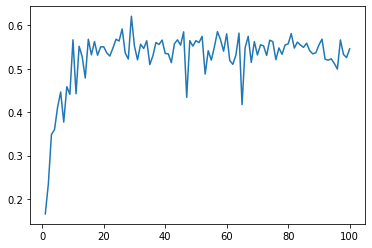

In [129]:
accuracies = [y for [x,y] in test_accuracy]
plt.plot(epoch_values,accuracies)


Looks like the best performance is somewhere around 20-25 epochs. 

In [141]:
lst = [epoch_values, accuracies]

test_df = pd.DataFrame(list(zip(epoch_values, accuracies)), 
               columns =['Epochs', 'Accuracy']) 

In [142]:
print(test_df.head())

   Epochs  Accuracy
0  1       0.165600
1  2       0.235200
2  3       0.348533
3  4       0.360000
4  5       0.411733


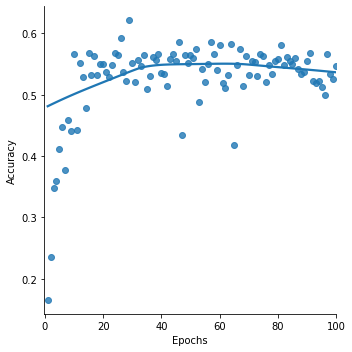

In [159]:

import seaborn


graph = seaborn.lmplot('Epochs', 'Accuracy', data = test_df, lowess=True)
graph.set(xlim = (-0.25,100))

Looks like 30 epochs yields the best performance. 